In [139]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Классификация текстов

In [140]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [141]:
clf

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range={4, 6})),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [142]:
import re
from nltk.corpus import stopwords

In [143]:
from pymystem3 import Mystem
m = Mystem()

In [144]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslanpepa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [145]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


# def lemmatize(text, mystem=m):
#     try:
#         return "".join(m.lemmatize(text)).strip()  
#     except:
#         return " "

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [146]:
df = pd.read_json('/Users/ruslanpepa/Netology/Машинное обучение/NLP/banki_responses.json', lines=True)

In [147]:
df = df.iloc[:10000]
len(df)

10000

In [148]:
len(df)

10000

In [149]:
df.columns

Index(['city', 'rating_not_checked', 'title', 'num_comments', 'bank_license',
       'author', 'bank_name', 'datetime', 'text', 'rating_grade'],
      dtype='object')

In [150]:
# df = df.iloc[15000:]
len(df)

10000

In [151]:
df.replace(to_replace='', value=NaN, inplace=True, regex=True)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Воронеж,True,Ипотека на 5+,0,лицензия № 1623,e.novikova,ВТБ 24,2015-06-08 11:06:56,Здравствуйте! Хотелось бы выразить благодарно...,5.0
1,г. Казань,True,ЗВОНКИ СОСЕДЯМ,0,лицензия № 2289,KZN\Vorontsova_NA,Русский Стандарт,2015-06-06 18:17:52,Уважаемые представители департамента по работе...,2.0
2,г. Санкт-Петербург,True,Ложная информация!!!!,0,лицензия № 2307,Evgenia15,Союз,2015-06-07 19:08:33,Здравствуйте. Столкнулась с такой ситуацией. в...,2.0
3,г. Москва,True,Банкомат не зачислил деньги на счет,1,лицензия № 2557,dolgov.work,Ситибанк,2015-06-07 19:22:00,1 июня 2015 в Москве в отделении по адресу Смо...,1.0
4,г. Волгоград,True,Невозможно закрыть карту 2(два)!!!,0,лицензия № 3354,copLine,Ренессанс Кредит,2015-06-08 14:54:55,История очень долгая! Пришел я в банк (это раз...,1.0
...,...,...,...,...,...,...,...,...,...,...
9995,г. Ярославль,False,"Очень долгое рассмотрение заявки на кредит ""Пр...",3,лицензия № 2272,Galinka2015._,Росбанк,2015-04-07 01:37:45,Здравствуйте! С 13.12.2010 по 19.06.2014 я явл...,NaN
9996,г. Нижний Новгород,False,Незаконное оформление кредита третьими лицамии...,2,лицензия № 2289,irchen,Русский Стандарт,2015-04-07 00:47:24,23.03.2015 примерно в 15-00ч по адресу г.Нижни...,NaN
9997,г. Курск,False,Кредит: условия досрочного погашения,0,лицензия № 1326,subv,Альфа-Банк,2015-04-07 01:45:41,В феврале 2015 года взял потребительский креди...,1.0
9998,г. Москва,True,"Двойное списание по карте, жду возврата денег ...",1,лицензия № 1481,buh-outsourcing,Сбербанк России,2015-04-07 14:47:00,Добрый день! в ноябре 2014 года при оплате штр...,1.0


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   city                10000 non-null  object        
 1   rating_not_checked  10000 non-null  bool          
 2   title               9988 non-null   object        
 3   num_comments        10000 non-null  int64         
 4   bank_license        9997 non-null   object        
 5   author              10000 non-null  object        
 6   bank_name           10000 non-null  object        
 7   datetime            10000 non-null  datetime64[ns]
 8   text                10000 non-null  object        
 9   rating_grade        6020 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 713.0+ KB


In [153]:
%%time
# df.text = df.text.apply(preprocess)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 8.11 µs


## Генсим

### TfidfModel

In [154]:
df.text

0       Здравствуйте!  Хотелось бы выразить благодарно...
1       Уважаемые представители департамента по работе...
2       Здравствуйте. Столкнулась с такой ситуацией. в...
3       1 июня 2015 в Москве в отделении по адресу Смо...
4       История очень долгая! Пришел я в банк (это раз...
                              ...                        
9995    Здравствуйте! С 13.12.2010 по 19.06.2014 я явл...
9996    23.03.2015 примерно в 15-00ч по адресу г.Нижни...
9997    В феврале 2015 года взял потребительский креди...
9998    Добрый день! в ноябре 2014 года при оплате штр...
9999    Добрый день, 05 марта 2015 года мною в ваш кол...
Name: text, Length: 10000, dtype: object

In [155]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [156]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [157]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [158]:
corpus_tfidf

In [159]:
type(corpus_tfidf)

gensim.interfaces.TransformedCorpus

In [ ]:
%%time
# num_features = len(corpus_tfidf)
index = similarities.MatrixSimilarity(corpus_tfidf, num_features=len(corpus_tfidf))
sims = index[corpus_tfidf]

In [169]:
sims[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [170]:
import seaborn as sns

In [173]:
from gensim.models import lsimodel

In [174]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 39.3 s, sys: 33.2 s, total: 1min 12s
Wall time: 18 s


In [175]:
lsi.show_topics(5)

[(0,
  '0.130*"я" + 0.122*"-" + 0.122*"мне" + 0.094*"меня" + 0.094*"что" + 0.088*"о" + 0.088*"Я" + 0.086*"у" + 0.084*"банка" + 0.083*"по"'),
 (1,
  '0.276*"звонки" + 0.253*"номер" + 0.186*"персональных" + 0.181*"телефона" + 0.177*"поступают" + 0.175*"мой" + 0.163*"удалить" + 0.155*"базы" + 0.155*"обработку" + 0.147*"данных"'),
 (2,
  '-0.156*"денежных" + -0.149*"средств" + -0.147*"денежные" + -0.141*"средства" + -0.138*"г." + -0.126*"2015" + 0.116*"-" + -0.106*"заявление" + -0.100*"размере" + -0.098*"№"'),
 (3,
  '-0.199*"кредит" + 0.195*"карты" + 0.184*"карту" + 0.169*"деньги" + -0.149*"кредита" + 0.120*"карта" + 0.109*"банкомат" + -0.101*"договора" + 0.100*"обязательствам," + -0.099*"страхования"'),
 (4,
  '-0.231*"вклад" + -0.227*"вклада" + -0.119*"-" + 0.110*"мне" + -0.103*"условия" + -0.093*"ЦБ" + -0.088*"благодарность" + -0.082*"очень" + 0.081*"смс" + 0.080*"номер"')]

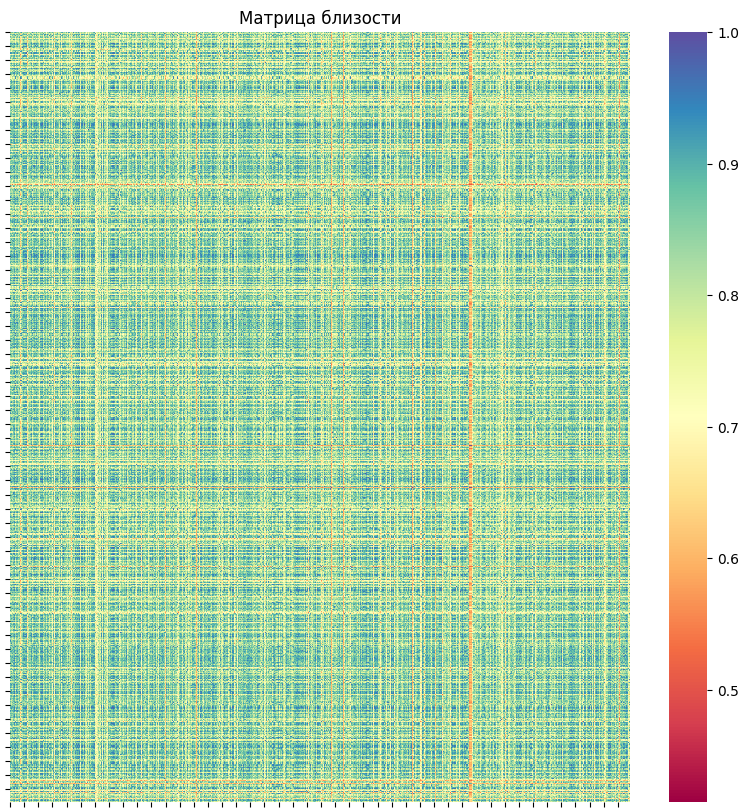

In [179]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()